# 1. PREPARAÇÃO

## 1.1 Importação de Bibliotecas

Importar todas as bibliotecas de análise de dados, visualização, pré-processamento, modelagem, métricas e explicabilidade.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import json
import joblib
import sklearn
from pathlib import Path
from datetime import datetime

from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

from scipy.stats import chi2_contingency
from scipy.stats import loguniform, randint




## 1.2 Carregamento da Base

Ler os dados do dataset.

Conferir colunas, tipos de variáveis e a coluna alvo (gravidade).

In [ ]:
PATH_ARQUIVO_ORIGINAL = "acidentes_enriquecidos.parquet"

if PATH_ARQUIVO_ORIGINAL.endswith(".parquet"):
    df = pd.read_parquet(PATH_ARQUIVO_ORIGINAL)
elif PATH_ARQUIVO_ORIGINAL.endswith(".csv"):
    try:
        df = pd.read_csv(PATH_ARQUIVO_ORIGINAL, sep=";", encoding="latin-1", low_memory=False)
    except Exception:
        df = pd.read_csv(PATH_ARQUIVO_ORIGINAL, sep=",", encoding="utf-8", low_memory=False)
else:
    raise ValueError("Formato de arquivo não suportado. Use .csv ou .parquet")

print("Dataset carregado:", df.shape)
display(df.head())

✅ Dataset carregado: (2009408, 30)


,data_hora,ano,hora,dia_semana,uf,rodovia,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,ambiguidade_uf,nome_feriado,eh_feriado
0,2010-10-29 14:20:00,2010,14,Sexta,RS,285,397.3,Santa Bárbara do Sul,Condução/manobra inadequada,Saída de pista,...,0,5,0,0,1,-28.381611,-53.306780,None,None,False
1,2010-12-14 22:00:00,2010,22,Terça,SP,116,406.5,Miracatu,Outras,Colisão com objeto,...,0,1,0,0,1,-24.331014,-47.628865,None,None,False
2,2010-03-07 16:00:00,2010,16,Domingo,BA,407,220.8,Capim Grosso,Condução/manobra inadequada,Capotamento,...,2,1,0,2,1,-11.276966,-40.022103,None,None,False
3,2010-10-26 14:20:00,2010,14,Terça,BA,116,567.0,Nova Itarana,Outras,Colisão com objeto,...,0,1,0,0,1,-12.986252,-39.944144,None,None,False
4,2010-09-15 12:30:00,2010,12,Quarta,SE,101,107.0,São Cristóvão,Comportamento do condutor,Colisão com objeto,...,0,0,0,2,1,-10.960470,-37.253522,None,None,False


In [ ]:
df_acidentes = df

## 1.3 Declaração de variáveis e funções

Declarar funções que serão utilizadas no decorrer da análise

In [ ]:
TARGET = 'classificacao_acidente'  # Variável alvo
PATH_ARQUIVO_ORGINAL = 'datasets/acidentes_enriquecidos.parquet'
TESTE_SIZE = 0.2
RANDOM_STATE = 42


In [ ]:
def obter_nulos(df):
    """Retorna um DataFrame com a contagem e proporção de valores nulos por coluna."""
    soma = df.isna().sum().sort_values(ascending=False).head(10)
    linhas = len(df)

    def decidir_impacto(linha):
        """Decide a ação a ser tomada de acordo com o impacto."""
        if linha['proporcao'] > 0.3:
            return 'alto'
        elif linha['proporcao'] > 0.05:
            return 'médio'
        elif linha['proporcao'] > 0:
            return 'baixo'
        else:
            return 'nenhum'

    df_nulos = pd.DataFrame({'quantidade': soma, 'proporcao': soma/linhas})

    df_nulos['impacto'] = df_nulos.apply(decidir_impacto, axis=1)

    return df_nulos

def remover_nulos(df, df_nulos):
    """Remove nulos de acordo com o impacto."""
    df_result = df.copy()

    alto_impacto_cols = df_nulos[df_nulos['impacto'] == 'alto'].index
    df_result = df_result.drop(columns=alto_impacto_cols, axis=1)

    return df_result



In [ ]:
def identificar_e_reportar_outliers(df, colunas):
    """
    Identifica e reporta a quantidade total e a proporção de linhas
    que contêm outliers em qualquer uma das colunas especificadas.

    Args:
        df (pd.DataFrame): O DataFrame para análise.
        colunas (list): Lista de nomes de colunas numéricas para verificar.

    Returns:
        list: Uma lista de índices únicos correspondentes às linhas que
              contêm pelo menos um outlier.
    """
    print("\n--- Análise de Outliers pelo Método IQR ---")
    # Usar um set para armazenar os índices garante que não haverá duplicatas
    outliers_indices = set()

    for coluna in colunas:
        # Garante que a coluna é numérica antes de calcular
        if not pd.api.types.is_numeric_dtype(df[coluna]):
            print(f"Coluna: '{coluna}' | Ignorada (não é numérica).")
            continue

        q1 = df[coluna].quantile(0.25)
        q3 = df[coluna].quantile(0.75)
        iqr = q3 - q1
        limite_inferior = q1 - 1.5 * iqr
        limite_superior = q3 + 1.5 * iqr

        # Identifica os índices dos outliers para a coluna atual
        outliers_coluna = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)].index

        # Adiciona os índices encontrados ao conjunto geral
        outliers_indices.update(outliers_coluna)

    # Relatório final após varrer todas as colunas
    qtd_outliers = len(outliers_indices)
    proporcao = qtd_outliers / len(df) if len(df) > 0 else 0

    print(f"\nTotal de {qtd_outliers} linhas ({proporcao:.2%}) com pelo menos um outlier detectado.")
    if proporcao > 0.05:
        print("Atenção: A proporção de outliers é significativa. Melhor não remover.")

    return sorted(list(outliers_indices))

In [ ]:
def remover_duplicatas(df, subset=None, keep='first'):
    """Remove linhas duplicadas de um DataFrame."""
    num_duplicatas = df.duplicated(subset=subset).sum()
    if num_duplicatas > 0:
        print(f"Linhas duplicadas: {num_duplicatas}.")
        df_limpo = df.drop_duplicates(subset=subset, keep=keep)
        return df_limpo
    else:
        print("Nenhuma duplicata para remover.")
        return df

In [ ]:
def cramers_v(confusion_matrix):
    """Calcula o V de Cramer a partir de uma tabela de contingência."""
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def cramers_v_for_all(df, target):
    results = {}
    cat_cols = df.select_dtypes(include=["object","category"]).columns.drop(target, errors="ignore")

    for col in cat_cols:
        confusion = pd.crosstab(df[col], df[target])
        v = cramers_v(confusion)
        results[col] = v

    return pd.Series(results).sort_values(ascending=False)

# 2 LIMPEZA E PRÉ-PROCESSAMENTO
## 2.1 Análise inicial de valores ausentes

Calcular total e porcentagem de nulos por variável.

Classificar impacto: baixo (<5%), médio (5–30%) e alto (>30%).

Decidir: imputar, prever com outro dataset (merge) ou descartar variável.

Justificativa: garante rastreabilidade e mostra criticidade dos nulos.


`nome_feriado` e `ambiguidade_uf` podem ser deletadas.

In [ ]:
df_nulos = obter_nulos(df_acidentes)
df_nulos.style.format({'proporcao': '{:.4%}'})
df_acidentes_limpo = remover_nulos(df_acidentes, df_nulos)


## 2.2 Tratamento de inconsistências e outliers

Detectar outliers estatísticos (IQR, Z-Score).

Verificar outliers contextuais (ex: velocidade = 300 km/h, datas no futuro).

Criar tabela de padronização para categorias divergentes (“chuvisco” = “chuva leve”).

Justificativa: evita que erros de digitação ou dados ilógicos contaminem o modelo.


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_acidentes_limpo.describe()

,data_hora,ano,hora,rodovia,km,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude
count,2009408,2009408.00,2009408.00,2009079.00,2009079.00,2009408.00,2009408.00,2009408.00,2009408.00,2009408.00,2009408.00,2009408.00,2009408.00,2004727.00,2004727.00
mean,2013-10-18 15:18:43.073245440,2013.30,13.07,211.88,261.92,2.20,0.06,0.54,0.19,1.33,0.10,0.72,1.72,-556.00,-2097.41
min,2007-01-01 00:00:00,2007.00,0.00,0.00,-870.30,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,-1033382874.00,-4016764289.00
25%,2010-06-17 09:26:15,2010.00,8.00,101.00,78.80,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,-25.17,-49.65
50%,2013-02-25 01:00:00,2013.00,14.00,153.00,201.00,2.00,0.00,0.00,0.00,1.00,0.00,0.00,2.00,-20.60,-46.59
75%,2016-07-30 18:41:15,2016.00,18.00,324.00,411.00,2.00,0.00,1.00,0.00,2.00,0.00,1.00,2.00,-13.07,-42.32
max,2023-06-30 23:30:00,2023.00,23.00,958.00,9967.10,103.00,33.00,58.00,46.00,99.00,86.00,66.00,25.00,163.00,717.00
std,NaN,4.28,5.87,129.19,229.13,1.63,0.29,1.00,0.55,1.31,0.40,1.19,0.73,730170.42,2837331.89


In [ ]:
df_acidentes_limpo.describe(include=['object', 'category'])

,dia_semana,uf,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo
count,2009408,2009408,2009408,2009408,2009408,2009383,2009408,2009408,2009408,2009408,2009408,2009408
unique,7,27,2336,13,17,4,4,3,7,3,11,2
top,Sexta,MG,Curitiba,Comportamento do condutor,Colisão traseira,Sem vítimas,Pleno dia,Crescente,Céu claro,Simples,Reta,Urbano
freq,326124,287960,27069,794035,518193,996841,1160102,1037488,1274375,1040421,1395057,1013697


In [ ]:
features_num = ['pessoas', 'feridos', 'mortos', 'feridos_graves', 'feridos_leves', 'ilesos', 'veiculos', 'km']
indices_outliers = identificar_e_reportar_outliers(df_acidentes_limpo, features_num)




--- Análise de Outliers pelo Método IQR ---

Total de 513289 linhas (25.54%) com pelo menos um outlier detectado.
Atenção: A proporção de outliers é significativa. Melhor não remover.


## 2.3. Identificação de duplicatas

Diferenciar duplicatas exatas (remover diretamente) de parciais (corrigir divergências ou consolidar registros).

Justificativa: garante consistência sem perder dados úteis.


In [ ]:
colunas_chave = ['data_hora', 'rodovia', 'km', 'tipo_acidente', 'pessoas']
mascara_duplicatas = df_acidentes_limpo.duplicated(subset=colunas_chave, keep=False)

df_duplicadas = df_acidentes_limpo[mascara_duplicatas]
df_duplicadas.sort_values(by=colunas_chave).head(8)


,data_hora,ano,hora,dia_semana,uf,rodovia,km,municipio,causa_acidente,tipo_acidente,...,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,eh_feriado
1586927,2007-01-01 09:50:00,2007,9,Segunda,MA,316,516.10,Caxias,Condução/manobra inadequada,Capotamento,...,0,0,0,2,0,0,2,-4.77,-43.63,True
1712658,2007-01-01 09:50:00,2007,9,Segunda,MA,316,516.10,Caxias,Condução/manobra inadequada,Capotamento,...,0,0,0,2,0,0,2,-4.77,-43.63,True
1588455,2007-01-03 18:00:00,2007,18,Quarta,RJ,116,190.00,Queimados,Outras,Colisão com objeto,...,0,0,0,1,0,0,1,-22.74,-43.50,False
1588462,2007-01-03 18:00:00,2007,18,Quarta,RJ,116,190.00,Queimados,Outras,Colisão com objeto,...,0,0,0,1,0,0,1,-22.74,-43.50,False
1589430,2007-01-05 16:00:00,2007,16,Sexta,RJ,101,209.00,Casimiro de Abreu,Outras,Colisão frontal,...,1,1,6,0,0,7,2,-22.48,-42.23,False
1712967,2007-01-05 16:00:00,2007,16,Sexta,RJ,101,209.00,Casimiro de Abreu,Outras,Colisão frontal,...,1,1,6,0,0,7,2,-22.48,-42.23,False
1588532,2007-01-06 18:40:00,2007,18,Sábado,DF,60,8.00,Brasília,Outras,Colisão transversal,...,0,0,0,2,0,0,2,-15.90,-48.13,False
1712629,2007-01-06 18:40:00,2007,18,Sábado,DF,60,8.00,Brasília,Outras,Colisão transversal,...,0,0,0,2,0,0,2,-15.90,-48.13,False


In [ ]:

df_acidentes_sem_duplicatas = remover_duplicatas(df_acidentes_limpo, subset=colunas_chave, keep='first')
df_acidentes_sem_duplicatas.shape

Linhas duplicadas: 33638.


(1975770, 28)

## 2.4. Padronização de tipos de dados

Converter colunas numéricas (ex: valores, contagens).

Converter categóricas para category.

Padronizar datas para datetime.

Justificativa: previne erros no pipeline e facilita transformações posteriores.


In [ ]:
df_acidentes_sem_duplicatas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1975770 entries, 0 to 2009407
Data columns (total 28 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   data_hora               datetime64[ns]
 1   ano                     Int64         
 2   hora                    int64         
 3   dia_semana              category      
 4   uf                      object        
 5   rodovia                 Int64         
 6   km                      float64       
 7   municipio               object        
 8   causa_acidente          category      
 9   tipo_acidente           category      
 10  classificacao_acidente  category      
 11  fase_dia                category      
 12  sentido_via             category      
 13  condicao_metereologica  category      
 14  tipo_pista              category      
 15  tracado_via             category      
 16  uso_solo                category      
 17  pessoas                 Int64         
 18  mortos 

In [ ]:
pd.DataFrame({'valores_unicos': df_acidentes_sem_duplicatas.nunique().sort_values(ascending=False), 'tipo_de_dado': df_acidentes_sem_duplicatas.dtypes}).sort_values(by='valores_unicos', ascending=False)

,valores_unicos,tipo_de_dado
data_hora,937867,datetime64[ns]
latitude,473027,float64
longitude,473018,float64
km,11033,float64
municipio,2336,object
rodovia,210,Int64
pessoas,79,Int64
ilesos,67,Int64
feridos,59,Int64
feridos_leves,52,Int64


In [ ]:
df_acidentes_sem_duplicatas.loc[:, 'uf'] = df_acidentes_sem_duplicatas['uf'].astype('category')


## 2.5. Imputação de valores ausentes

Numéricos: média, mediana ou KNNImputer.

Categóricos: moda ou categoria “desconhecido”.

Justificativa: mantém consistência sem enviesar muito os dados.


In [ ]:
obter_nulos(df_acidentes_sem_duplicatas).style.format({'proporcao': '{:.4%}'})


,quantidade,proporcao,impacto
longitude,4673,0.2365%,baixo
latitude,4673,0.2365%,baixo
km,280,0.0142%,baixo
rodovia,280,0.0142%,baixo
classificacao_acidente,23,0.0012%,baixo
hora,0,0.0000%,nenhum
dia_semana,0,0.0000%,nenhum
uf,0,0.0000%,nenhum
municipio,0,0.0000%,nenhum
causa_acidente,0,0.0000%,nenhum


`classificacao_acidente` parece só se baseia nas colunas de `mortos`, `feridos`, `ignorados` então dá para preencher

In [ ]:
df_acidentes_sem_duplicatas['classificacao_acidente'].value_counts()

classificacao_acidente
Sem vítimas            989060
Com vítimas feridas    884237
Com vítimas fatais      90970
Ignorado                11480
Name: count, dtype: int64

In [ ]:
df_acidentes_limpo = df_acidentes_sem_duplicatas.copy()

conditions = [
    df_acidentes_limpo['mortos'] > 0,
    df_acidentes_limpo['feridos'] > 0
]

choices = [
    'Com vítimas fatais',
    'Com vítimas feridas'
]

df_acidentes_limpo['classificacao_acidente'] = np.select(conditions, choices, default='Sem vítimas')

obter_nulos(df_acidentes_limpo).style.format({'proporcao': '{:.4%}'})


,quantidade,proporcao,impacto
longitude,4673,0.2365%,baixo
latitude,4673,0.2365%,baixo
km,280,0.0142%,baixo
rodovia,280,0.0142%,baixo
dia_semana,0,0.0000%,nenhum
hora,0,0.0000%,nenhum
uf,0,0.0000%,nenhum
municipio,0,0.0000%,nenhum
causa_acidente,0,0.0000%,nenhum
tipo_acidente,0,0.0000%,nenhum


Neste caso, vamos apenas deletar os valores ausentes, já que a média não faz sentido para as colunas que têm valores ausentes e o KNNImputer demanda muito poder computacional.

In [ ]:
df_acidentes_limpo = df_acidentes_limpo.dropna()

## 2.6. Codificação de variáveis categóricas

Ordinais (ex: “leve < grave < fatal”): OrdinalEncoder.

Nominais: OneHotEncoder (com cuidado para alta cardinalidade).

Justificativa: permite ao modelo interpretar corretamente variáveis não numéricas.


In [ ]:
colunas_ordinais = ['dia_semana', 'fase_dia', 'condicao_metereologica']
ordem_dia_semana = ['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado']
ordem_fase_dia = ['Amanhecer', 'Pleno dia', 'Anoitecer', 'Plena noite']
ordem_condicao_metereologica = ['Céu claro', 'Nublado', 'Vento', 'Chuva',
                                'Nevoeiro/Neblina', 'Granizo', 'Neve', 'Ignorada']

categorias_ordinais = [ordem_dia_semana, ordem_fase_dia, ordem_condicao_metereologica]

pipeline_cat_ordinal = Pipeline(
    steps=[
        ('ordinal', OrdinalEncoder(categories=categorias_ordinais, handle_unknown='use_encoded_value', unknown_value=-1)),
    ]
)

pipeline_cat_nominal = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]
)



## 2.7. Normalização e padronização

StandardScaler ou MinMaxScaler, dependendo do modelo:

SVM e Regressão Logística → sensíveis a escala.

Árvores de decisão / Random Forest → menos sensíveis.

Justificativa: garante comparabilidade entre variáveis numéricas.


In [ ]:
pipeline_standard_scaler = Pipeline(
    steps=[
        ('standard_scaler', StandardScaler())
    ]
)


In [ ]:
pipeline_min_max_scaler = Pipeline(
    steps=[
        ('min_max_scaler', MinMaxScaler())
    ]
)


## 2.8. Gerando novas features

Gerando features para reduzir algumas possibilidades de dados.
Aqui removemos também features que são apenas visíveis apos o acidente e como queremos saber se teve ou não vitimas, o ideal é termos as informações pré acidente apenas


In [ ]:
# --- 1) Engenharia de Features ---
df_engineered = df_acidentes_sem_duplicatas.dropna().copy()

# data_hora -> componentes
df_engineered['data_hora'] = pd.to_datetime(df_engineered['data_hora'], errors='coerce')
df_engineered['dia_semana'] = df_engineered['data_hora'].dt.day_name()
df_engineered['mes'] = df_engineered['data_hora'].dt.month
df_engineered['hora'] = df_engineered['data_hora'].dt.hour

# turno do dia
def turno(h):
    if 5 <= h < 8: return "Amanhecer"
    elif 8 <= h < 18: return "Pleno dia"
    elif 18 <= h < 21: return "Anoitecer"
    else: return "Plena noite"
df_engineered['turno_dia'] = df_engineered['hora'].apply(turno)

# condição climática simplificada
def simplifica_clima(x):
    if not isinstance(x, str): return "Ignorado"
    x = x.lower()
    if "chuva" in x: return "Chuva"
    if "neblin" in x: return "Neblina"
    if "nublado" in x: return "Nublado"
    if "vento" in x: return "Vento"
    if "granizo" in x: return "Granizo"
    if "neve" in x: return "Neve"
    if "claro" in x: return "Céu claro"
    return "Ignorado"
df_engineered['clima_simplificado'] = df_engineered['condicao_metereologica'].apply(simplifica_clima)

post_accidente_cols = [
    "mortos",
    "feridos_leves",
    "feridos_graves",
    "ilesos",
    "ignorados",
    "feridos",
    "pessoas",
    "veiculos"
]

# cria uma cópia sem essas colunas
df_engineered = df_engineered.drop(columns=post_accidente_cols, errors="ignore")



In [ ]:
#Podemos observar as novas features agora!
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1970794 entries, 0 to 2009407
Data columns (total 23 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   data_hora               datetime64[ns]
 1   ano                     Int64         
 2   hora                    int32         
 3   dia_semana              object        
 4   uf                      object        
 5   rodovia                 Int64         
 6   km                      float64       
 7   municipio               object        
 8   causa_acidente          category      
 9   tipo_acidente           category      
 10  classificacao_acidente  category      
 11  fase_dia                category      
 12  sentido_via             category      
 13  condicao_metereologica  category      
 14  tipo_pista              category      
 15  tracado_via             category      
 16  uso_solo                category      
 17  latitude                float64       
 18  longitu

## 2.9. Verificação de correção para encontrar as melhores opcoes

Aqui usamos a verificação de Cramers e análise de correlaçao para vermos quais variaveis estão relacionadas com a variavel alvo.
Cramers para categoricas e analise padrão para as númericas

In [ ]:
cv_results = cramers_v_for_all(df_engineered, TARGET)
print(cv_results)

tipo_acidente            0.26
municipio                0.15
causa_acidente           0.10
tracado_via              0.09
uso_solo                 0.08
uf                       0.08
tipo_pista               0.07
fase_dia                 0.07
turno_dia                0.06
clima_simplificado       0.05
condicao_metereologica   0.05
dia_semana               0.05
sentido_via              0.01
dtype: float64


In [ ]:
# copia para não sujar o original
df_corr = df_engineered.copy()

# converte alvo categórico em numérico
df_corr[TARGET + "_num"] = df_corr[TARGET].astype("category").cat.codes

# seleciona apenas numéricas
num_cols = df_corr.select_dtypes(include=[np.number]).columns.drop(TARGET + "_num", errors="ignore")

# correlação simples (Pearson)
corrs = df_corr[num_cols].corrwith(df_corr[TARGET + "_num"]).sort_values(key=abs, ascending=False)

print(corrs)


ano         -0.29
rodovia     -0.03
hora        -0.02
mes         -0.01
km          -0.00
latitude    -0.00
longitude   -0.00
dtype: float64


As correlações não sao boas, principalmente as númericas, então vamos remove-las.
Um ponto de atenção é o ano, que pode indicar que com o passar dos anos, o número de acidentes foi diminuindo

In [ ]:
low_corr_cols = [
    "rodovia",
    "hora",
    "mes",
    "km",
    "latitude",
    "longitude",
    "sentido_via"
]

# cria cópia sem essas colunas
df_engineered = df_engineered.drop(columns=low_corr_cols, errors="ignore")
print("Colunas removidas por baixa correlação:", low_corr_cols)


Colunas removidas por baixa correlação: ['rodovia', 'hora', 'mes', 'km', 'latitude', 'longitude', 'sentido_via']


## 2.10. Integração em pipeline

Transformaremos a classificaçao acidente em binária. Ou tem vítima, ou não. Também vamos começar a montar a pipeline, fazendo o onehot encoding nos categoricos e scalando os númericos

In [ ]:
df_engineered["classificacao_binaria"] = df_engineered["classificacao_acidente"].replace({
    "Sem vítimas": "Sem vítimas",
    "Com vítimas feridas": "Com vítimas",
    "Com vítimas fatais": "Com vítimas",
    "Ignorado": "Ignorado"   # opcional: pode tratar como NaN
})

# se quiser forçar só 2 classes (descartar Ignorado):
df_engineered = df_engineered[df_engineered["classificacao_binaria"] != "Ignorado"].copy()

# ou, se preferir, já transforma em 0/1
df_engineered["vitimas"] = df_engineered["classificacao_binaria"].map({
    "Sem vítimas": 0,
    "Com vítimas": 1
})

df_engineered.drop(columns=["classificacao_acidente", "classificacao_binaria"], errors="ignore", inplace=True)

C:\Users\matheus\AppData\Local\Temp\ipykernel_17800\2389757356.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_engineered["classificacao_binaria"] = df_engineered["classificacao_acidente"].replace({


In [ ]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1959338 entries, 0 to 2009407
Data columns (total 16 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   data_hora               datetime64[ns]
 1   ano                     Int64         
 2   dia_semana              object        
 3   uf                      object        
 4   municipio               object        
 5   causa_acidente          category      
 6   tipo_acidente           category      
 7   fase_dia                category      
 8   condicao_metereologica  category      
 9   tipo_pista              category      
 10  tracado_via             category      
 11  uso_solo                category      
 12  eh_feriado              bool          
 13  turno_dia               object        
 14  clima_simplificado      object        
 15  vitimas                 float64       
dtypes: Int64(1), bool(1), category(7), datetime64[ns](1), float64(1), object(5)
memory usage: 151.4

In [ ]:
# númericas
num_proc = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# categóricas
cat_proc = Pipeline(steps=[
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])


X = df_engineered.drop(columns=["vitimas"])
y = df_engineered["vitimas"]



preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_proc, X.select_dtypes(include=np.number).columns),
        ("cat", cat_proc, X.select_dtypes(include=["object","category","bool"]).columns)
    ]
)


X_small = X.sample(100000, random_state=42)
y_small = y.loc[X_small.index]



In [ ]:
# Criação de X e y reduzidos para testes preliminares
X_small.shape, y_small.shape

((100000, 15), (100000,))

# 3 Análise Exploratória e Estatística (EDA)

## 3.1 Estrutura do dataset

In [ ]:
print("Formato (linhas, colunas):", df.shape)
display(df.head(5))
display(df.info())
nulos_top = df.isna().sum().sort_values(ascending=False).head(15)
display(nulos_top)

# Frases-resumo
lin, col = df.shape
anos = (int(df["ano"].min()), int(df["ano"].max())) if "ano" in df.columns and df["ano"].notna().any() else (None, None)

print("\n### Resumo — Estrutura e qualidade dos dados")
print(f"- O dataset possui **{lin:,}** linhas e **{col}** colunas.")
if all(anos):
    print(f"- Período coberto: **{anos[0]}–{anos[1]}**.")
if nulos_top.iloc[0] > 0:
    print("- Variáveis com mais ausências:")
    for idx, val in nulos_top.items():
        if val > 0:
            print(f"  • {idx}: {val:,} nulos")
print("- Datas convertidas em **ano/mês** (quando disponíveis) e colunas numéricas coerçadas.")

Formato (linhas, colunas): (2009408, 30)


,data_hora,ano,hora,dia_semana,uf,rodovia,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,ambiguidade_uf,nome_feriado,eh_feriado
0,2010-10-29 14:20:00,2010,14,Sexta,RS,285,397.30,Santa Bárbara do Sul,Condução/manobra inadequada,Saída de pista,...,0,5,0,0,1,-28.38,-53.31,None,None,False
1,2010-12-14 22:00:00,2010,22,Terça,SP,116,406.50,Miracatu,Outras,Colisão com objeto,...,0,1,0,0,1,-24.33,-47.63,None,None,False
2,2010-03-07 16:00:00,2010,16,Domingo,BA,407,220.80,Capim Grosso,Condução/manobra inadequada,Capotamento,...,2,1,0,2,1,-11.28,-40.02,None,None,False
3,2010-10-26 14:20:00,2010,14,Terça,BA,116,567.00,Nova Itarana,Outras,Colisão com objeto,...,0,1,0,0,1,-12.99,-39.94,None,None,False
4,2010-09-15 12:30:00,2010,12,Quarta,SE,101,107.00,São Cristóvão,Comportamento do condutor,Colisão com objeto,...,0,0,0,2,1,-10.96,-37.25,None,None,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009408 entries, 0 to 2009407
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   data_hora               datetime64[ns]
 1   ano                     Int64         
 2   hora                    int64         
 3   dia_semana              category      
 4   uf                      object        
 5   rodovia                 Int64         
 6   km                      float64       
 7   municipio               object        
 8   causa_acidente          category      
 9   tipo_acidente           category      
 10  classificacao_acidente  category      
 11  fase_dia                category      
 12  sentido_via             category      
 13  condicao_metereologica  category      
 14  tipo_pista              category      
 15  tracado_via             category      
 16  uso_solo                category      
 17  pessoas                 Int64         
 18  mo

None

ambiguidade_uf            2007397
nome_feriado              1935752
latitude                     4681
longitude                    4681
rodovia                       329
km                            329
classificacao_acidente         25
dia_semana                      0
causa_acidente                  0
municipio                       0
uf                              0
hora                            0
ano                             0
data_hora                       0
condicao_metereologica          0
dtype: int64


### Resumo — Estrutura e qualidade dos dados
- O dataset possui **2,009,408** linhas e **30** colunas.
- Período coberto: **2007–2023**.
- Variáveis com mais ausências:
  • ambiguidade_uf: 2,007,397 nulos
  • nome_feriado: 1,935,752 nulos
  • latitude: 4,681 nulos
  • longitude: 4,681 nulos
  • rodovia: 329 nulos
  • km: 329 nulos
  • classificacao_acidente: 25 nulos
- Datas convertidas em **ano/mês** (quando disponíveis) e colunas numéricas coerçadas.


## 3.2 Estatísticas descritivas

In [ ]:
num_cols = [c for c in ["pessoas","mortos","feridos","feridos_leves","feridos_graves","ilesos","veiculos"] if c in df.columns]
if num_cols:
    display(df[num_cols].describe().T)

def smean(c): return df[c].mean() if c in df.columns else np.nan

print("\n### Destaques — Tendência central e dispersão")
if "pessoas" in df.columns and "veiculos" in df.columns:
    print(f"- Em média, cada ocorrência envolve **{smean('pessoas'):.2f}** pessoas e **{smean('veiculos'):.2f}** veículos.")
if "feridos" in df.columns:
    print(f"- **Feridos por ocorrência** (média): **{smean('feridos'):.2f}**.")
if "mortos" in df.columns:
    print(f"- **Mortos por ocorrência** (média): **{smean('mortos'):.3f}** (baixa frequência, porém alta gravidade).")
print("- Há casos com muitos envolvidos (dispersão alta), sugerindo **outliers**.")

,count,mean,std,min,25%,50%,75%,max
pessoas,2009408.00,2.20,1.63,1.00,1.00,2.00,2.00,103.00
mortos,2009408.00,0.06,0.29,0.00,0.00,0.00,0.00,33.00
feridos,2009408.00,0.72,1.19,0.00,0.00,0.00,1.00,66.00
feridos_leves,2009408.00,0.54,1.00,0.00,0.00,0.00,1.00,58.00
feridos_graves,2009408.00,0.19,0.55,0.00,0.00,0.00,0.00,46.00
ilesos,2009408.00,1.33,1.31,0.00,1.00,1.00,2.00,99.00
veiculos,2009408.00,1.72,0.73,1.00,1.00,2.00,2.00,25.00



### Destaques — Tendência central e dispersão
- Em média, cada ocorrência envolve **2.20** pessoas e **1.72** veículos.
- **Feridos por ocorrência** (média): **0.72**.
- **Mortos por ocorrência** (média): **0.056** (baixa frequência, porém alta gravidade).
- Há casos com muitos envolvidos (dispersão alta), sugerindo **outliers**.


## 3.3 Padrões temporais e regionais

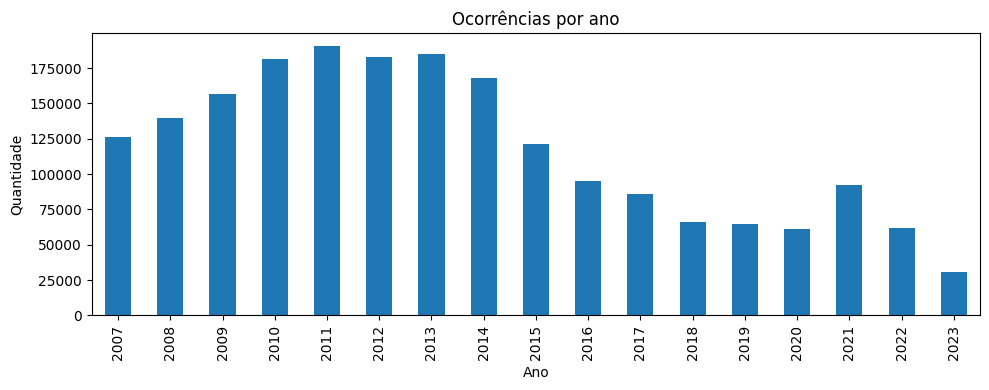

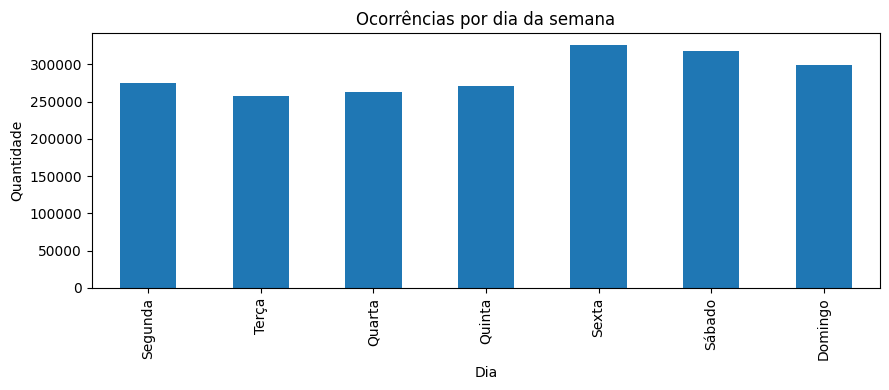

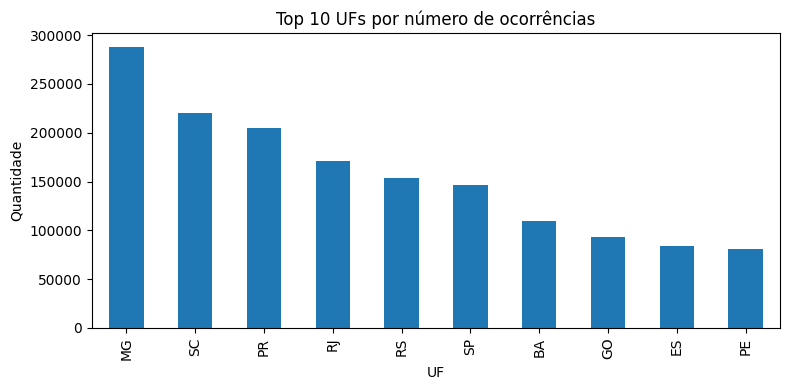

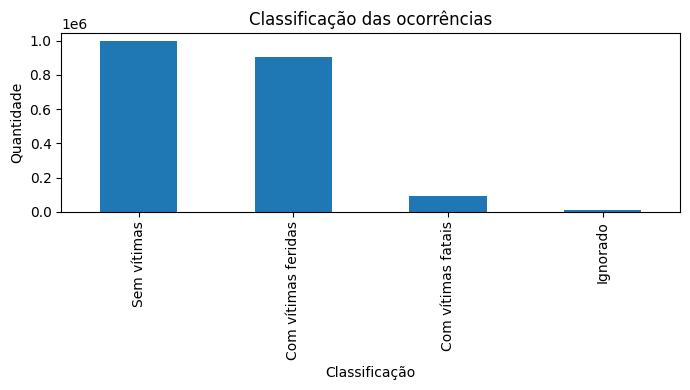


### Resumo — Padrões
- Ano com maior volume: **2011**.
- Dia com mais ocorrências: **Sexta**.
- UF com mais registros: **MG**.
- Distribuição de gravidade (aprox.): Sem vítimas: 49.6%; Com vítimas feridas: 45.2%; Com vítimas fatais: 4.6%; Ignorado: 0.6%


In [ ]:

# Ano
if "ano" in df.columns:
    cont_ano = df["ano"].value_counts().sort_index()
    plt.figure(figsize=(10,4))
    cont_ano.plot(kind="bar")
    plt.title("Ocorrências por ano"); plt.xlabel("Ano"); plt.ylabel("Quantidade")
    plt.tight_layout(); plt.show()

# Dia da semana (normaliza rótulos)
serie_dia = None
if "dia_semana" in df.columns:
    serie_dia = df["dia_semana"].astype(str).replace({
        "segunda-feira":"Segunda","terça-feira":"Terça","quarta-feira":"Quarta",
        "quinta-feira":"Quinta","sexta-feira":"Sexta","sábado":"Sábado","domingo":"Domingo",
        "Segunda-feira":"Segunda","Terça-feira":"Terça","Quarta-feira":"Quarta",
        "Quinta-feira":"Quinta","Sexta-feira":"Sexta","Sábado":"Sábado","Domingo":"Domingo"
    })
    ordem = ["Segunda","Terça","Quarta","Quinta","Sexta","Sábado","Domingo"]
    cont = serie_dia.value_counts().reindex(ordem)
    if cont.notna().any():
        cont = cont.dropna()
        plt.figure(figsize=(9,4))
        cont.plot(kind="bar")
        plt.title("Ocorrências por dia da semana"); plt.xlabel("Dia"); plt.ylabel("Quantidade")
        plt.tight_layout(); plt.show()

# UF
if "uf" in df.columns:
    top_uf = df["uf"].value_counts().head(10)
    plt.figure(figsize=(8,4))
    top_uf.plot(kind="bar")
    plt.title("Top 10 UFs por número de ocorrências"); plt.xlabel("UF"); plt.ylabel("Quantidade")
    plt.tight_layout(); plt.show()

# Classificação (gravidade)
col_class = None
for cand in ["classificacao_acidente","classificação_acidente"]:
    if cand in df.columns:
        col_class = cand
        break

if col_class:
    cont_class = df[col_class].value_counts()
    plt.figure(figsize=(7,4))
    cont_class.plot(kind="bar")
    plt.title("Classificação das ocorrências"); plt.xlabel("Classificação"); plt.ylabel("Quantidade")
    plt.tight_layout(); plt.show()

# Resumo textual
print("\n### Resumo — Padrões")
if "ano" in df.columns and df["ano"].notna().any():
    print(f"- Ano com maior volume: **{df['ano'].value_counts().idxmax()}**.")
if serie_dia is not None and not serie_dia.empty:
    print(f"- Dia com mais ocorrências: **{serie_dia.value_counts().idxmax()}**.")
if "uf" in df.columns and not df["uf"].dropna().empty:
    print(f"- UF com mais registros: **{df['uf'].value_counts().idxmax()}**.")
if col_class:
    dist = df[col_class].value_counts(normalize=True)*100
    txt = "; ".join([f"{k}: {v:.1f}%" for k,v in dist.items()])
    print(f"- Distribuição de gravidade (aprox.): {txt}")

## 3.4 Fatores de gravidade

In [ ]:
# Descobrir nomes corretos (com/sem acento)
col_class = None
for cand in ["classificacao_acidente", "classificação_acidente"]:
    if cand in df.columns:
        col_class = cand
        break

col_meteo = "condicao_meteorologica" if "condicao_meteorologica" in df.columns else ("condição_meteorologica" if "condição_meteorologica" in df.columns else None)
col_pista = "tipo_pista" if "tipo_pista" in df.columns else None
col_fase  = "fase_dia" if "fase_dia" in df.columns else None

if not col_class:
    raise ValueError("Não encontrei a coluna de classificação do acidente.")

# Cria coluna binária de fatalidade
df = df.copy()
df["_fatal"] = df[col_class].astype(str).str.contains("fata", case=False, na=False).astype(int)

def taxa_fatalidade(categ_col):
    tmp = df[[categ_col, "_fatal"]].dropna()
    if tmp.empty:
        return None
    tab = (tmp.groupby(categ_col)["_fatal"]
             .mean()
             .sort_values(ascending=False)
             .mul(100)
             .round(2)
             .to_frame("Taxa de fatalidade (%)"))
    return tab

# Mostrar tabelas
if col_pista:
    print("Taxa de fatalidade por **tipo de pista** (%):")
    display(taxa_fatalidade(col_pista))

if col_meteo:
    print("\nTaxa de fatalidade por **condição meteorológica** (%):")
    display(taxa_fatalidade(col_meteo))

if col_fase:
    print("\nTaxa de fatalidade por **fase do dia** (%):")
    display(taxa_fatalidade(col_fase))

Taxa de fatalidade por **tipo de pista** (%):


C:\Users\matheus\AppData\Local\Temp\ipykernel_17800\3004181007.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (tmp.groupby(categ_col)["_fatal"]


,Taxa de fatalidade (%)
tipo_pista,
Simples,6.25
Dupla,2.98
Múltipla,2.34



Taxa de fatalidade por **fase do dia** (%):


C:\Users\matheus\AppData\Local\Temp\ipykernel_17800\3004181007.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (tmp.groupby(categ_col)["_fatal"]


,Taxa de fatalidade (%)
fase_dia,
Plena noite,7.10
Amanhecer,6.63
Anoitecer,4.56
Pleno dia,3.11


In [ ]:
# Frases prontas para conclusão — Fatores de gravidade
conclusoes_fatores = []

def pick_top(col):
    tab = taxa_fatalidade(col)
    if tab is not None and not tab.empty:
        return tab.index[0], float(tab.iloc[0,0])
    return None, None

if col_pista:
    top_cat, top_val = pick_top(col_pista)
    if top_cat is not None:
        conclusoes_fatores.append(f"No fator **tipo de pista**, a maior taxa de fatalidade ocorre em **{top_cat}** (**{top_val:.1f}%**).")

if col_meteo:
    top_cat, top_val = pick_top(col_meteo)
    if top_cat is not None:
        conclusoes_fatores.append(f"Quanto à **condição meteorológica**, o destaque negativo é **{top_cat}**, com **{top_val:.1f}%** de fatalidade.")

if col_fase:
    top_cat, top_val = pick_top(col_fase)
    if top_cat is not None:
        conclusoes_fatores.append(f"Na **fase do dia**, o maior percentual de óbitos está em **{top_cat}** (**{top_val:.1f}%**).")

print("### Conclusão — Fatores de Gravidade\n")
if conclusoes_fatores:
    for frase in conclusoes_fatores:
        print("-", frase)
else:
    print("- Não foi possível gerar frases.")

### Conclusão — Fatores de Gravidade

- No fator **tipo de pista**, a maior taxa de fatalidade ocorre em **Simples** (**6.2%**).
- Na **fase do dia**, o maior percentual de óbitos está em **Plena noite** (**7.1%**).


C:\Users\matheus\AppData\Local\Temp\ipykernel_17800\3004181007.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (tmp.groupby(categ_col)["_fatal"]
C:\Users\matheus\AppData\Local\Temp\ipykernel_17800\3004181007.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (tmp.groupby(categ_col)["_fatal"]


## 3.5 Frases prontas — Padrões temporais e regionais

In [ ]:
conclusoes_padroes = []

if "ano" in df.columns and df["ano"].notna().any():
    ano_pico = int(df["ano"].value_counts().idxmax())
    conclusoes_padroes.append(f"O **ano de pico** em registros é **{ano_pico}**.")

if "dia_semana" in df.columns:
    serie_dia = df["dia_semana"].astype(str).replace({
        "segunda-feira":"Segunda","terça-feira":"Terça","quarta-feira":"Quarta",
        "quinta-feira":"Quinta","sexta-feira":"Sexta","sábado":"Sábado","domingo":"Domingo",
        "Segunda-feira":"Segunda","Terça-feira":"Terça","Quarta-feira":"Quarta",
        "Quinta-feira":"Quinta","Sexta-feira":"Sexta","Sábado":"Sábado","Domingo":"Domingo"
    })
    if not serie_dia.dropna().empty:
        dia_top = serie_dia.value_counts().idxmax()
        conclusoes_padroes.append(f"O **dia da semana** com mais ocorrências é **{dia_top}**.")

if "uf" in df.columns and not df["uf"].dropna().empty:
    uf_top = df["uf"].value_counts().idxmax()
    conclusoes_padroes.append(f"A **UF com mais registros** é **{uf_top}**.")

print("### Conclusão — Padrões\n")
if conclusoes_padroes:
    for frase in conclusoes_padroes:
        print("-", frase)
else:
    print("- Não foi possível gerar frases.")

### Conclusão — Padrões

- O **ano de pico** em registros é **2011**.
- O **dia da semana** com mais ocorrências é **Sexta**.
- A **UF com mais registros** é **MG**.


## 3.6 Correlação e outliers

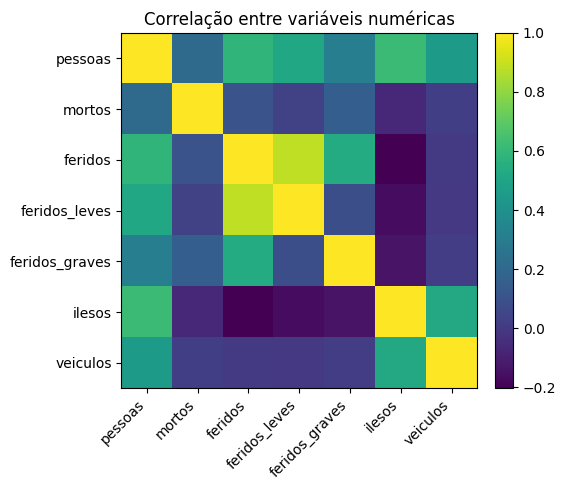

,pessoas,mortos,feridos,feridos_leves,feridos_graves,ilesos,veiculos
pessoas,1.00,0.21,0.58,0.52,0.31,0.62,0.45
mortos,0.21,1.00,0.10,0.03,0.16,-0.07,0.02
feridos,0.58,0.10,1.00,0.89,0.54,-0.20,0.00
feridos_leves,0.52,0.03,0.89,1.00,0.09,-0.16,-0.00
feridos_graves,0.31,0.16,0.54,0.09,1.00,-0.14,0.01
ilesos,0.62,-0.07,-0.20,-0.16,-0.14,1.00,0.52
veiculos,0.45,0.02,0.00,-0.00,0.01,0.52,1.00


- Limite superior IQR para **mortos** ≈ 0.00; registros acima: 92,965.
- Limite superior IQR para **feridos** ≈ 2.50; registros acima: 97,025.
- Limite superior IQR para **feridos_graves** ≈ 0.00; registros acima: 291,195.
- Limite superior IQR para **feridos_leves** ≈ 2.50; registros acima: 61,974.


In [ ]:
# Correlação entre variáveis numéricas
corr_cols = [c for c in ["pessoas","mortos","feridos","feridos_leves","feridos_graves","ilesos","veiculos"] if c in df.columns]
if len(corr_cols) >= 2:
    corr = df[corr_cols].corr()
    plt.figure(figsize=(6,5))
    im = plt.imshow(corr, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
    plt.yticks(range(len(corr_cols)), corr_cols)
    plt.title("Correlação entre variáveis numéricas")
    plt.tight_layout(); plt.show()
    display(corr)

def outlier_iqr(serie):
    q1, q3 = serie.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q3 + 1.5*iqr

for alvo in ["mortos","feridos","feridos_graves","feridos_leves"]:
    if alvo in df.columns:
        lim = outlier_iqr(df[alvo].dropna())
        qtd = int((df[alvo] > lim).sum())
        print(f"- Limite superior IQR para **{alvo}** ≈ {lim:.2f}; registros acima: {qtd:,}.")

## 3.7 Conclusão geral — prontos para o relatório

In [ ]:
bullets = []

lin, col = df.shape
bullets.append(f"- Registros: **{lin:,}**, colunas: **{col}**.")

if "ano" in df.columns and df["ano"].notna().any():
    bullets.append(f"- Ano de pico: **{int(df['ano'].value_counts().idxmax())}**.")

if "uf" in df.columns and not df["uf"].dropna().empty:
    bullets.append(f"- UF com mais ocorrências: **{df['uf'].value_counts().idxmax()}**.")

try:
    for frase in conclusoes_padroes:
        bullets.append(f"- {frase}")
except Exception:
    pass

try:
    for frase in conclusoes_fatores:
        bullets.append(f"- {frase}")
except Exception:
    pass

if "mortos" in df.columns:
    bullets.append(f"- **Mortos por ocorrência (média)**: **{df['mortos'].mean():.3f}**.")
if "feridos" in df.columns:
    bullets.append(f"- **Feridos por ocorrência (média)**: **{df['feridos'].mean():.2f}**.")
if "veiculos" in df.columns:
    bullets.append(f"- **Veículos por ocorrência (média)**: **{df['veiculos'].mean():.2f}**.")

print("\n".join(bullets))

- Registros: **2,009,408**, colunas: **31**.
- Ano de pico: **2011**.
- UF com mais ocorrências: **MG**.
- O **ano de pico** em registros é **2011**.
- O **dia da semana** com mais ocorrências é **Sexta**.
- A **UF com mais registros** é **MG**.
- No fator **tipo de pista**, a maior taxa de fatalidade ocorre em **Simples** (**6.2%**).
- Na **fase do dia**, o maior percentual de óbitos está em **Plena noite** (**7.1%**).
- **Mortos por ocorrência (média)**: **0.056**.
- **Feridos por ocorrência (média)**: **0.72**.
- **Veículos por ocorrência (média)**: **1.72**.


# 4 MODELAGEM DE ALGORITMOS DE TREINAMENTO

## 4.1 Dicionário de modelos

In [ ]:
# Dicionário contendo os modelos a serem treinados
models = {
    "Regressão Logística": LogisticRegression(random_state=42, max_iter=1000),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "KNN (K-Nearest Neighbors)": KNeighborsClassifier(n_neighbors=5)
}

## 4.2 Divisão treino e teste das bases 'small'

In [ ]:
#Dividindo os dados em treino e teste
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.2, random_state=42, stratify=y_small)

## 4.3 Cross-Validation

In [ ]:

# Dicionário para armazenar os resultados da validação cruzada
resultados = {}

# Criar validação cruzada com 5 folds
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop para treinar e avaliar cada modelo no dicionário
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Executar a validação cruzada no conjunto de treino
    scores = cross_val_score(pipeline, X_train_small, y_train_small, cv=cv_strategy, scoring='accuracy')

    # Armazenando os resultados
    resultados[model_name] = {
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std()
    }

    print(f"Modelo: {model_name}")
    print(f"Acurácia Média (CV): {scores.mean():.4f} (+/- {scores.std():.4f})")

# Df dos resultados
resultados_df = pd.DataFrame(resultados).T.sort_values(by='mean_accuracy', ascending=False)

print("\n--- Resultados Consolidados da Validação Cruzada ---")
print(resultados_df)

Modelo: Regressão Logística
Acurácia Média (CV): 0.7187 (+/- 0.0026)
Modelo: Árvore de Decisão
Acurácia Média (CV): 0.6696 (+/- 0.0029)
Modelo: KNN (K-Nearest Neighbors)
Acurácia Média (CV): 0.6640 (+/- 0.0011)

--- Resultados Consolidados da Validação Cruzada ---
                           mean_accuracy  std_accuracy
Regressão Logística                 0.72          0.00
Árvore de Decisão                   0.67          0.00
KNN (K-Nearest Neighbors)           0.66          0.00


Algoritmo com melhor resultado: Regressão Logística

## 4.4 Dividindo treino e teste da base total

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 4.5 Treino e teste do modelo escolhido

In [ ]:


# Selecionando o melhor modelo com base nos resultados da validação cruzada
melhor_modelo = resultados_df.index[0]
nome_melhor_modelo = models[melhor_modelo]

print(f"--- Treinamento final do melhor modelo: {nome_melhor_modelo} ---")

# Criando o pipeline final para o melhor modelo
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', nome_melhor_modelo)
])

# Treinando o pipeline com os dados de treino
final_pipeline.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = final_pipeline.predict(X_test)

# Avaliando o desempenho final
accuracy_final = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\nAcurácia no conjunto de teste: {accuracy_final:.4f}\n")
print("Relatório de Classificação Detalhado:")
print(report)

--- Treinamento final do melhor modelo: LogisticRegression(max_iter=1000, random_state=42) ---

Acurácia no conjunto de teste: 0.7239

Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

         0.0       0.70      0.78      0.74    197167
         1.0       0.75      0.67      0.71    194701

    accuracy                           0.72    391868
   macro avg       0.73      0.72      0.72    391868
weighted avg       0.73      0.72      0.72    391868



# 5 AVALIAÇÃO E OTIMIZAÇÃO DO MODELO
## 5.1. ROC-AUC e RMSE

ROC-AUC: 0.7916
RMSE (probabilidades): 0.4303


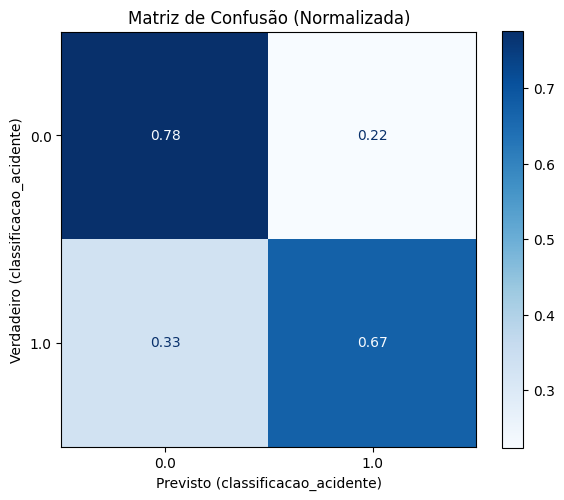

In [ ]:
# Item 1 — Avaliação essencial: ROC-AUC, RMSE de probabilidade e Matriz de Confusão


# Usar o pipeline final já treinado
pipeline_to_eval = final_pipeline
X_eval, y_eval = X_test, y_test

# Probabilidades e predições
y_proba = pipeline_to_eval.predict_proba(X_eval)
y_pred_eval = pipeline_to_eval.predict(X_eval)

# Classes e cardinalidade
classes = pipeline_to_eval.named_steps['classifier'].classes_
n_classes = len(classes)

# ROC-AUC (binário: único valor; multiclasse: macro)
if n_classes == 2:
    roc_auc_val = float(roc_auc_score(y_eval, y_proba[:, 1]))
    print(f"ROC-AUC: {roc_auc_val:.4f}")
else:
    roc_auc_val = float(roc_auc_score(y_eval, y_proba, multi_class='ovr', average='macro'))
    print(f"ROC-AUC (macro): {roc_auc_val:.4f}")

# RMSE das probabilidades (funciona para binário e multiclasse)
idx_map = {c: i for i, c in enumerate(classes)}
Y_onehot = np.zeros_like(y_proba)
for i, y_true in enumerate(y_eval):
    Y_onehot[i, idx_map[y_true]] = 1
rmse_prob = float(np.sqrt(((Y_onehot - y_proba) ** 2).mean()))
print(f"RMSE (probabilidades): {rmse_prob:.4f}")

# Matriz de confusão (normalizada) — eixos com o nome real da label
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_eval,
    y_pred_eval,
    normalize='true',
    cmap='Blues',
    ax=ax
)
ax.set_title("Matriz de Confusão (Normalizada)")
# Usa TARGET quando disponível; caso contrário, mantém rótulos padrões
try:
    target_name = TARGET
except NameError:
    target_name = 'target'
ax.set_xlabel(f"Previsto ({target_name})")
ax.set_ylabel(f"Verdadeiro ({target_name})")
plt.tight_layout()
plt.show()

# Variáveis auxiliares
roc_auc_info = {'roc_auc': roc_auc_val}
rmse_prob_final = rmse_prob
y_pred_item1 = y_pred_eval

## 5.2. Ajuste de Hiperparâmetros

In [ ]:
# Item 2 — Ajuste de Hiperparâmetros (leve, dividido em etapas)


# 2.1 — Setup leve de CV e amostragem estratificada (subconjunto para tuning)
best_name = resultados_df.index[0]
best_estimator = models[best_name]

# Reduz CV para acelerar e diminuir consumo
tune_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Usa apenas ~30% do conjunto de treino para a busca (estratificado)
X_tune, _, y_tune, _ = train_test_split(
    X_train,
    y_train,
    test_size=0.7,
    random_state=42,
    stratify=y_train,
)

print(f"Modelo base: {best_name}")
print(f"Tamanho para tuning: {X_tune.shape} | CV folds: {tune_cv.get_n_splits()}")

# Baseline: pipeline simples com o melhor modelo ANTES do tuning
baseline_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_estimator)])
baseline_pipeline.fit(X_train, y_train)

# Métricas baseline no teste
y_pred_base = baseline_pipeline.predict(X_test)
baseline_acc_test = float(accuracy_score(y_test, y_pred_base))

# ROC-AUC baseline (binário: único; multiclasse: macro)
if hasattr(baseline_pipeline.named_steps['classifier'], 'predict_proba'):
    y_proba_base = baseline_pipeline.predict_proba(X_test)
    if y_proba_base.shape[1] == 2:
        baseline_auc_test = float(roc_auc_score(y_test, y_proba_base[:, 1]))
    else:
        baseline_auc_test = float(roc_auc_score(y_test, y_proba_base, multi_class='ovr', average='macro'))
else:
    baseline_auc_test = None

print(f"Baseline -> Acc teste: {baseline_acc_test:.4f} | ROC-AUC: {baseline_auc_test:.4f}" if baseline_auc_test is not None else f"Baseline -> Acc teste: {baseline_acc_test:.4f} | ROC-AUC: N/A")

Modelo base: Regressão Logística
Tamanho para tuning: (470241, 15) | CV folds: 3
Baseline -> Acc teste: 0.7239 | ROC-AUC: 0.7916


In [ ]:
# 2.2 — Espaços de busca mínimos por modelo


scoring = 'accuracy'

if best_name.lower().startswith('regressão logística'):
    search_kind = 'random'
    estimator = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_estimator)])
    search_space = {
        'classifier__C': loguniform(1e-2, 1e1),
        'classifier__class_weight': [None, 'balanced']
    }
elif best_name.lower().startswith('árvore de decisão'):
    search_kind = 'grid'
    estimator = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_estimator)])
    search_space = {
        'classifier__max_depth': [None, 10],
        'classifier__min_samples_leaf': [1, 5]
    }
elif best_name.lower().startswith('knn'):
    search_kind = 'random'
    estimator = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_estimator)])
    search_space = {
        'classifier__n_neighbors': randint(3, 35),
        'classifier__weights': ['uniform', 'distance']
    }
else:
    search_kind = 'grid'
    estimator = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_estimator)])
    search_space = {}

print(f"Tipo de busca: {search_kind} | Espaço: {list(search_space.keys())}")

Tipo de busca: random | Espaço: ['classifier__C', 'classifier__class_weight']


In [ ]:
# 2.3 — Rodar busca leve e atualizar o pipeline final
if search_kind == 'random':
    search = RandomizedSearchCV(
        estimator,
        param_distributions=search_space,
        n_iter=8,
        scoring=scoring,
        cv=tune_cv,
        n_jobs=-1,
        random_state=42,
        refit=True,
        verbose=1
    )
elif search_kind == 'grid':
    search = GridSearchCV(
        estimator,
        param_grid=search_space,
        scoring=scoring,
        cv=tune_cv,
        n_jobs=-1,
        refit=True,
        verbose=1
    )
else:
    search = None

if search is not None:
    search.fit(X_tune, y_tune)
    final_pipeline = search.best_estimator_
    print("Melhor (CV)", f"{search.best_score_:.4f}")
    print("Parâmetros:", search.best_params_)

    # Avaliar no teste completo
    tuned_pred = final_pipeline.predict(X_test)
    tuned_acc_test = float(accuracy_score(y_test, tuned_pred))

    if hasattr(final_pipeline.named_steps['classifier'], 'predict_proba'):
        tuned_proba = final_pipeline.predict_proba(X_test)
        if tuned_proba.shape[1] == 2:
            tuned_auc_test = float(roc_auc_score(y_test, tuned_proba[:, 1]))
        else:
            tuned_auc_test = float(roc_auc_score(y_test, tuned_proba, multi_class='ovr', average='macro'))
    else:
        tuned_auc_test = None

    print(f"Acurácia teste: {tuned_acc_test:.4f} | ROC-AUC: {tuned_auc_test:.4f}" if tuned_auc_test is not None else f"Acurácia teste: {tuned_acc_test:.4f} | ROC-AUC: N/A")

    # Atualiza referências globais
    accuracy_final = tuned_acc_test
    best_params = search.best_params_
else:
    print("Sem busca configurada para este modelo.")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Melhor (CV) 0.7228
Parâmetros: {'classifier__C': np.float64(0.21751953118777648), 'classifier__class_weight': None}
Acurácia teste: 0.7232 | ROC-AUC: 0.7909


## 5.3. Análise de erros e refinamento do pipeline

In [ ]:
# Item 3 — Análise de erros


# Relatório de classificação resumido
print("Relatório de Classificação (pós-tuning):\n")
print(classification_report(y_test, final_pipeline.predict(X_test)))

# Amostras de erros (até 10)
y_pred_now = final_pipeline.predict(X_test)
err_idx = np.where(pd.Series(y_test).values != y_pred_now)[0][:10]
if len(err_idx) > 0:
    print("\nErros (primeiros até 10): índice | y_true -> y_pred")
    for i in err_idx:
        print(f"{i}: {y_test.iloc[i]} -> {y_pred_now[i]}")
else:
    print("\nSem erros no teste.")

Relatório de Classificação (pós-tuning):

              precision    recall  f1-score   support

         0.0       0.70      0.78      0.74    197167
         1.0       0.75      0.67      0.71    194701

    accuracy                           0.72    391868
   macro avg       0.73      0.72      0.72    391868
weighted avg       0.73      0.72      0.72    391868


Erros (primeiros até 10): índice | y_true -> y_pred
0: 0.0 -> 1.0
4: 1.0 -> 0.0
8: 0.0 -> 1.0
13: 1.0 -> 0.0
18: 0.0 -> 1.0
19: 0.0 -> 1.0
20: 0.0 -> 1.0
22: 1.0 -> 0.0
23: 1.0 -> 0.0
25: 0.0 -> 1.0


## 5.4. Preparação para exportação e reuso do modelo

Nesta etapa vamos:
- Persistir o `final_pipeline` (pré-processamento + classificador) com `joblib`.
- Salvar metadados (modelo, data/hora, métricas principais, classes, versão do sklearn).
- Mostrar um exemplo de como carregar e usar o modelo salvo para previsões.

Em produção, garanta que o schema de entrada (colunas e tipos) seja compatível com o usado no treino. Opcionalmente, inclua validações de schema antes de prever.

In [ ]:
# Exportação do pipeline e metadados + exemplo de carga/uso


export_dir = Path(r"exported_model")
export_dir.mkdir(parents=True, exist_ok=True)

model_path = export_dir / 'modelo_final.joblib'
meta_path = export_dir / 'modelo_final_meta.json'

# Coleta de métricas principais disponíveis
metrics_export = {
    'accuracy_test': float(accuracy_final) if 'accuracy_final' in globals() else None,
    'roc_auc': roc_auc_info.get('roc_auc') if 'roc_auc_info' in globals() else None,
    'roc_auc_macro': roc_auc_info.get('roc_auc_macro') if 'roc_auc_info' in globals() else None,
    'roc_auc_weighted': roc_auc_info.get('roc_auc_weighted') if 'roc_auc_info' in globals() else None,
    'rmse_prob': float(rmse_prob_final) if 'rmse_prob_final' in globals() else None
}

# Persistência do pipeline completo
joblib.dump(final_pipeline, model_path)

# Metadados
metadata = {
    'saved_at': datetime.utcnow().isoformat() + 'Z',
    'best_model_name': resultados_df.index[0] if 'resultados_df' in globals() else None,
    'best_params': best_params if 'best_params' in globals() else None,
    'classes': final_pipeline.named_steps['classifier'].classes_.tolist(),
    'sklearn_version': sklearn.__version__,
    'metrics': metrics_export
}
meta_path.write_text(json.dumps(metadata, ensure_ascii=False, indent=2), encoding='utf-8')

print(f"Modelo salvo em: {model_path}")
print(f"Metadados salvos em: {meta_path}")

# Exemplo de carga e uso
loaded_pipeline = joblib.load(model_path)
print("Pipeline carregado. Exemplo de uso (primeiras 3 linhas do X_test):")
if 'X_test' in globals():
    X_small_example = X_test.iloc[:3].copy()
    print("Predições:", loaded_pipeline.predict(X_small_example))
    if hasattr(loaded_pipeline.named_steps['classifier'], 'predict_proba'):
        print("Probabilidades:", loaded_pipeline.predict_proba(X_small_example))


Modelo salvo em: exported_model\modelo_final.joblib
Metadados salvos em: exported_model\modelo_final_meta.json
Pipeline carregado. Exemplo de uso (primeiras 3 linhas do X_test):
Predições: [1. 1. 0.]
Probabilidades: [[0.30817634 0.69182366]
 [0.03973532 0.96026468]
 [0.69506426 0.30493574]]


C:\Users\matheus\AppData\Local\Temp\ipykernel_17800\3031174271.py:24: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'saved_at': datetime.utcnow().isoformat() + 'Z',
